In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 127 entries, PatientID to Mean_Entropy_Kiran
dtypes: bool(27), float64(86), int64(11), object(3)
memory usage: 12.7+ MB


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
nlst_democols['num'].pop('nodule')

['CoordX', 'CoordZ', 'CoordY']

In [5]:
nlst_democols['num']['other'].append('Mean_Entropy_Kiran')

In [6]:
nlst_democols

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter [mm]', 'Mean_Entropy_Kiran']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   'cancoral',
   'cancpanc',
   'canccerv',
  

In [6]:
nlst_preds = utils.prep_nlst_preds(nlst_preds_nodule, scanlevel=False, tijmen=False, sybil=False)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 123 entries, PatientID to LC_stage
dtypes: bool(25), float64(84), int64(11), object(3)
memory usage: 12.4+ MB


In [7]:
# nlst_policy_thresholds = pd.read_csv(f"{NLST_PREDS}/policy-thresholds-{len(nlst_preds)}.csv", index_col=0)
# nlst_policy_thresholds

In [8]:
THRESHOLD = 'Brock'

In [9]:
nlst_preds['WhiteOrBlack'] = nlst_preds['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
nlst_democols['cat']['demo'].append('WhiteOrBlack')

In [10]:
MODEL_TO_COL = {
    "Venkadesh": "DL_cal",
    # "de Haas Combined": "Thijmen_mean_cal",
    "de Haas Local": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (w/nodule)": "Thijmen_global_show_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [11]:
# nlst_preds['Kiran_pred_label'] = (nlst_preds[MODEL_TO_COL['Venkadesh']] > nlst_policy_thresholds.loc['Venkadesh', THRESHOLD]).astype(int).to_numpy()
nlst_preds['Kiran_pred_label'] = (nlst_preds[MODEL_TO_COL['Venkadesh']] > 0.06).astype(int).to_numpy()
nlst_preds['Kiran_PanCan_diff'] = nlst_preds[MODEL_TO_COL['Venkadesh']] - nlst_preds['PanCan2b']

In [12]:
false_positives = nlst_preds.query("label == 0 and Kiran_pred_label == 1")
false_negatives = nlst_preds.query("label == 1 and Kiran_pred_label == 0")

true_positives = nlst_preds.query("label == 1 and Kiran_pred_label == 1")
true_negatives = nlst_preds.query("label == 0 and Kiran_pred_label == 0")

## Difference between Training Info Splits

In [13]:
result_sets = {
    "FP": false_positives,
    "FN": false_negatives,
    "TP": true_positives,
    "TN": true_negatives, 
}

### utility code

In [14]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=result_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

In [15]:
def cat_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
        dfdict[f"{m}_freq"].fillna(0, inplace=True)
        dfdict[f"{m}_norm"].fillna(0, inplace=True)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)
    
    df = pd.DataFrame(dfdict).drop_duplicates()

    for m in dfsets:
        df[f"{m}_freq"] = df[f"{m}_freq"].fillna(0.0)
        df[f"{m}_norm"] = df[f"{m}_norm"].fillna(0.0)

    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                df[f"diff_norm_{m1}_{m2}"] = (df[f"{m1}_norm"] - df[f"{m2}_norm"]).round(4)    

    # df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [16]:
def num_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

### differences

In [17]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_sets).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).head(20)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
233,lungcanc,LC_stage,NaN,3414.0,100.0000,3.0,2.1127,28.0,2.5294,11414.0,100.0000,97.8873,97.4706,0.0000,-0.4167,-97.8873,-97.4706
198,nodule,SemiSolid,1.0,757.0,22.1734,0.0,0.0000,0.0,0.0000,715.0,6.2642,22.1734,22.1734,15.9092,0.0000,-6.2642,-6.2642
190,nodule,GroundGlassOpacity,1.0,635.0,18.5999,0.0,0.0000,0.0,0.0000,2976.0,26.0732,18.5999,18.5999,-7.4733,0.0000,-26.0732,-26.0732
24,demo,Gender,1.0,2008.0,58.8166,71.0,50.0000,656.0,59.2593,6546.0,57.3506,8.8166,-0.4427,1.4660,-9.2593,-7.3506,1.9087
10,demo,educat,5.0,736.0,21.5583,23.0,16.1972,281.0,25.3839,2499.0,21.8942,5.3611,-3.8256,-0.3359,-9.1867,-5.6970,3.4897
4,demo,marital,5.0,626.0,18.3363,19.0,13.3803,240.0,21.6802,2072.0,18.1531,4.9560,-3.3439,0.1832,-8.2999,-4.7728,3.5271
68,work,wrkfarm,1.0,454.0,13.2982,12.0,8.4507,109.0,9.8464,1245.0,10.9077,4.8475,3.4518,2.3905,-1.3957,-2.4570,-1.0613
41,smoke,pipe,1.0,765.0,22.4077,25.0,17.6056,272.0,24.5709,2376.0,20.8165,4.8021,-2.1632,1.5912,-6.9653,-3.2109,3.7544
202,other,wrknomask,1.0,945.0,27.6801,33.0,23.2394,273.0,24.6612,2785.0,24.3999,4.4407,3.0189,3.2802,-1.4218,-1.1605,0.2613
59,work,wrkchem,1.0,272.0,7.9672,6.0,4.2254,71.0,6.4137,714.0,6.2555,3.7418,1.5535,1.7117,-2.1883,-2.0301,0.1582


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
225,lungcanc,LC_stage,110.0,0.0,0.0000,91.0,64.0845,534.0,48.2385,0.0,0.0000,-64.0845,-48.2385,0.0000,15.8460,64.0845,48.2385
214,lungcanc,Adenocarcinoma,1.0,0.0,0.0000,61.0,42.9577,500.0,45.1671,0.0,0.0000,-42.9577,-45.1671,0.0000,-2.2094,42.9577,45.1671
212,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0000,33.0,23.2394,211.0,19.0605,0.0,0.0000,-23.2394,-19.0605,0.0000,4.1789,23.2394,19.0605
194,nodule,NonSolid,1.0,0.0,0.0000,29.0,20.4225,97.0,8.7624,0.0,0.0000,-20.4225,-8.7624,0.0000,11.6601,20.4225,8.7624
196,nodule,PartSolid,1.0,0.0,0.0000,24.0,16.9014,221.0,19.9639,0.0,0.0000,-16.9014,-19.9639,0.0000,-3.0625,16.9014,19.9639
216,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0000,23.0,16.1972,163.0,14.7245,0.0,0.0000,-16.1972,-14.7245,0.0000,1.4727,16.1972,14.7245
206,other,PersonalCancerHist,1.0,983.0,28.7932,59.0,41.5493,376.0,33.9657,3179.0,27.8518,-12.7561,-5.1725,0.9414,7.5836,13.6975,6.1139
204,other,FamilyHistoryLungCa,1.0,874.0,25.6005,52.0,36.6197,327.0,29.5393,2845.0,24.9255,-11.0192,-3.9388,0.6750,7.0804,11.6942,4.6138
186,nodule,NoduleInUpperLung,1.0,1814.0,53.1342,90.0,63.3803,676.0,61.0659,4166.0,36.4990,-10.2461,-7.9317,16.6352,2.3144,26.8813,24.5669
224,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0000,14.0,9.8592,110.0,9.9368,0.0,0.0000,-9.8592,-9.9368,0.0000,-0.0776,9.8592,9.9368


In [18]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_sets)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True).head(20)

,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
19,other,Diameter [mm],mean,11.1547,8.3972,15.1142,6.3864,2.7575,-3.9595,4.7683,-6.7170,2.0108,8.7278
18,other,Diameter [mm],50%,9.6000,7.4500,12.8000,5.5000,2.1500,-3.2000,4.1000,-5.3500,1.9500,7.3000
3,demo,weight,mean,179.4982,177.9155,175.4596,184.0172,1.5827,4.0386,-4.5190,2.4559,-6.1017,-8.5576
2,demo,weight,50%,177.0000,175.5000,173.0000,180.0000,1.5000,4.0000,-3.0000,2.5000,-4.5000,-7.0000
1,demo,height,mean,68.0690,67.3944,67.8397,67.9519,0.6746,0.2293,0.1171,-0.4453,-0.5575,-0.1122
17,other,NoduleCounts,mean,2.4241,2.1620,2.4119,2.6129,0.2621,0.0122,-0.1888,-0.2499,-0.4509,-0.2010
13,smoke,smokeday,mean,28.6593,28.5634,30.0750,28.4119,0.0959,-1.4157,0.2474,-1.5116,0.1515,1.6631
0,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,demo,Age,50%,63.0000,63.0000,64.0000,62.0000,0.0000,-1.0000,1.0000,-1.0000,1.0000,2.0000
12,smoke,smokeday,50%,25.0000,25.0000,30.0000,25.0000,0.0000,-5.0000,0.0000,-5.0000,0.0000,5.0000


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
8,smoke,pkyr,50%,51.2500,54.0000,57.0000,50.0000,-2.7500,-5.7500,1.2500,-3.0000,4.0000,7.0000
9,smoke,pkyr,mean,58.8407,60.9975,64.9514,57.1976,-2.1568,-6.1107,1.6431,-3.9539,3.7999,7.7538
14,smoke,smokeyr,50%,41.0000,43.0000,44.0000,41.0000,-2.0000,-3.0000,0.0000,-1.0000,2.0000,3.0000
15,smoke,smokeyr,mean,41.5146,43.0986,43.7100,40.7351,-1.5840,-2.1954,0.7795,-0.6114,2.3635,2.9749
10,smoke,smokeage,50%,16.0000,17.0000,16.0000,16.0000,-1.0000,0.0000,0.0000,1.0000,1.0000,0.0000
6,demo,BMI,50%,26.5784,27.1279,26.1672,27.2592,-0.5495,0.4112,-0.6808,0.9607,-0.1313,-1.0920
7,demo,BMI,mean,27.1225,27.5454,26.7176,27.9146,-0.4229,0.4049,-0.7921,0.8278,-0.3692,-1.1970
11,smoke,smokeage,mean,16.4335,16.7183,16.1599,16.6510,-0.2848,0.2736,-0.2175,0.5584,0.0673,-0.4911
5,demo,Age,mean,63.6245,63.8944,64.2855,63.0832,-0.2699,-0.6610,0.5413,-0.3911,0.8112,1.2023
0,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Now with the top 100 scores that were different from PanCan

In [19]:
result_top_100_diff = {
    "FP": false_positives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[0:100],
    "FN": false_negatives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[0:100],
}

In [20]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_top_100_diff).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).head(20)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
180,lungcanc,LC_stage,NaN,100.0,100.0,1.0,1.0,99.0
148,nodule,SemiSolid,1.0,16.0,16.0,0.0,0.0,16.0
76,disease,diagchro,1.0,19.0,19.0,7.0,7.0,12.0
82,disease,diagemph,1.0,22.0,22.0,12.0,12.0,10.0
151,other,wrknomask,1.0,34.0,34.0,24.0,24.0,10.0
20,demo,Gender,1.0,61.0,61.0,52.0,52.0,9.0
140,nodule,GroundGlassOpacity,1.0,7.0,7.0,0.0,0.0,7.0
42,work,wrkasbe,1.0,11.0,11.0,5.0,5.0,6.0
9,demo,educat,4.0,20.0,20.0,15.0,15.0,5.0
36,smoke,pipe,1.0,20.0,20.0,16.0,16.0,4.0


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
173,lungcanc,LC_stage,110.0,0.0,0.0,63.0,63.0,-63.0
163,lungcanc,Adenocarcinoma,1.0,0.0,0.0,49.0,49.0,-49.0
161,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0,23.0,23.0,-23.0
144,nodule,NonSolid,1.0,0.0,0.0,17.0,17.0,-17.0
34,smoke,cigsmok,1.0,50.0,50.0,64.0,64.0,-14.0
155,other,PersonalCancerHist,1.0,23.0,23.0,37.0,37.0,-14.0
136,nodule,NoduleInUpperLung,1.0,47.0,47.0,60.0,60.0,-13.0
165,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0,13.0,13.0,-13.0
153,other,FamilyHistoryLungCa,1.0,21.0,21.0,32.0,32.0,-11.0
21,demo,Gender,2.0,39.0,39.0,48.0,48.0,-9.0


In [21]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_top_100_diff)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True).head(20)

,category,attribute,value,FP,FN,diff_FP_FN
19,other,Diameter [mm],mean,11.2490,6.7890,4.4600
18,other,Diameter [mm],50%,10.2000,6.5000,3.7000
3,demo,weight,mean,179.8600,178.4300,1.4300
2,demo,weight,50%,180.0000,179.0000,1.0000
4,demo,Age,50%,64.0000,63.0000,1.0000
17,other,NoduleCounts,mean,2.6000,2.0500,0.5500
1,demo,height,mean,68.2400,67.8300,0.4100
5,demo,Age,mean,63.6700,63.4300,0.2400
0,demo,height,50%,68.0000,68.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000


,category,attribute,value,FP,FN,diff_FP_FN
12,smoke,smokeday,50%,20.0000,30.0000,-10.0000
8,smoke,pkyr,50%,47.0000,55.7500,-8.7500
9,smoke,pkyr,mean,56.7375,62.1700,-5.4325
14,smoke,smokeyr,50%,41.0000,43.0000,-2.0000
15,smoke,smokeyr,mean,41.4000,43.3400,-1.9400
13,smoke,smokeday,mean,27.4100,28.8900,-1.4800
6,demo,BMI,50%,26.2295,27.1279,-0.8984
11,smoke,smokeage,mean,16.2400,16.6500,-0.4100
7,demo,BMI,mean,27.0899,27.1351,-0.0452
0,demo,height,50%,68.0000,68.0000,0.0000


## False Positives

In [22]:
false_positives = nlst_preds.query("label == 0 and Kiran_pred_label == 1")
false_positives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[['SeriesInstanceUID', 'label', 'Kiran_pred_label', 'PanCan2b', 'DL_cal', 'Kiran_PanCan_diff']]

,SeriesInstanceUID,label,Kiran_pred_label,PanCan2b,DL_cal,Kiran_PanCan_diff
10095,1.2.840.113654.2.55.98861299711525430877993378...,0,1,0.027097,0.870740,0.843643
13841,1.3.6.1.4.1.14519.5.2.1.7009.9004.337737422324...,0,1,0.032591,0.821022,0.788431
6196,1.3.6.1.4.1.14519.5.2.1.7009.9004.317792465838...,0,1,0.030209,0.794943,0.764734
13121,1.3.6.1.4.1.14519.5.2.1.7009.9004.305261900952...,0,1,0.133418,0.830687,0.697270
7443,1.3.6.1.4.1.14519.5.2.1.7009.9004.101975354069...,0,1,0.111572,0.795541,0.683969
...,...,...,...,...,...,...
12412,1.2.840.113654.2.55.12214417867856293761715489...,0,1,0.641022,0.152304,-0.488718
10615,1.2.840.113654.2.55.40114302739641107006168416...,0,1,0.597842,0.069518,-0.528324
11569,1.2.840.113654.2.55.98591848380988807922321793...,0,1,0.726740,0.177436,-0.549304
13653,1.3.6.1.4.1.14519.5.2.1.7009.9004.147148054836...,0,1,0.693475,0.109388,-0.584087


<Axes: xlabel='Kiran_PanCan_diff', ylabel='Count'>

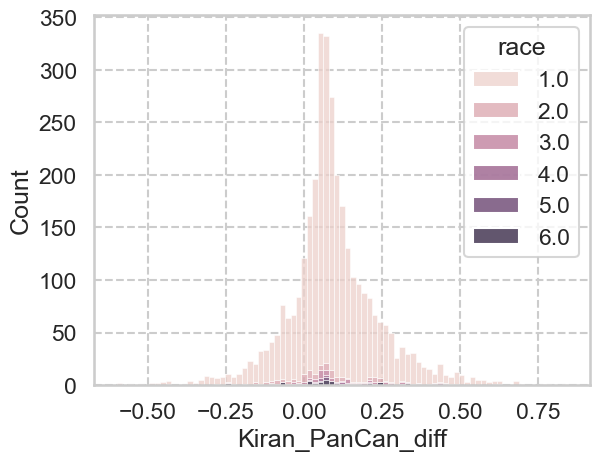

In [23]:
sns.histplot(false_positives, x='Kiran_PanCan_diff', hue='race', multiple='stack')

### Racial differences

In [24]:
race_fps = {
    "white": false_positives.query("race == 1"),
    "black": false_positives.query("race == 2"),
}

In [25]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fps).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).head(20)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
14,demo,race,1.0,3187.0,100.0000,0.0,0.0000,100.0000
27,demo,WhiteOrBlack,1.0,3187.0,100.0000,0.0,0.0000,100.0000
24,demo,NonHispanicWhite,True,3137.0,98.4311,0.0,0.0000,98.4311
1,demo,marital,2.0,2151.0,67.4929,36.0,38.7097,28.7832
22,demo,Married,True,2151.0,67.4929,36.0,38.7097,28.7832
35,smoke,pipe,1.0,753.0,23.6272,5.0,5.3763,18.2509
57,work,wrkfarm,1.0,432.0,13.5551,0.0,0.0000,13.5551
8,demo,educat,3.0,861.0,27.0160,14.0,15.0538,11.9622
38,smoke,smokelive,1.0,2806.0,88.0452,72.0,77.4194,10.6258
11,demo,educat,6.0,458.0,14.3709,4.0,4.3011,10.0698


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
15,demo,race,2.0,0.0,0.0000,93.0,100.0000,-100.0000
28,demo,WhiteOrBlack,2.0,0.0,0.0000,93.0,100.0000,-100.0000
33,smoke,cigsmok,1,1566.0,49.1371,66.0,70.9677,-21.8306
103,disease,diaghype,1.0,1107.0,34.7349,51.0,54.8387,-20.1038
7,demo,educat,2.0,202.0,6.3382,21.0,22.5806,-16.2424
2,demo,marital,3.0,290.0,9.0995,22.0,23.6559,-14.5564
44,work,wrkasbe,1.0,158.0,4.9576,17.0,18.2796,-13.3220
10,demo,educat,5.0,682.0,21.3994,31.0,33.3333,-11.9339
182,other,Emphysema,True,1218.0,38.2178,45.0,48.3871,-10.1693
91,disease,diagdiab,1.0,275.0,8.6288,17.0,18.2796,-9.6508


In [26]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fps)
display(num_demo_splits.sort_values(by='diff_white_black', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_white_black', ascending=True).head(20)

KeyError: "['max', 'min', 'std'] not found in axis"

## False Negatives

In [27]:
false_negatives.sort_values(by=['Kiran_PanCan_diff'], ascending=True)[['SeriesInstanceUID', 'label', 'Kiran_pred_label', 'PanCan2b', 'DL_cal', 'Kiran_PanCan_diff']]

,SeriesInstanceUID,label,Kiran_pred_label,PanCan2b,DL_cal,Kiran_PanCan_diff
15763,1.3.6.1.4.1.14519.5.2.1.7009.9004.143586271866...,1,0,0.525368,0.051651,-0.473717
15761,1.3.6.1.4.1.14519.5.2.1.7009.9004.175985546338...,1,0,0.481470,0.015758,-0.465713
15762,1.3.6.1.4.1.14519.5.2.1.7009.9004.276011104552...,1,0,0.450988,0.040701,-0.410287
13100,1.3.6.1.4.1.14519.5.2.1.7009.9004.132150608450...,1,0,0.435912,0.050518,-0.385394
12497,1.2.840.113654.2.55.12881149774656140035795514...,1,0,0.403346,0.021186,-0.382160
...,...,...,...,...,...,...
4715,1.2.840.113654.2.55.15505637602509032624908092...,1,0,0.009398,0.052898,0.043500
9821,1.2.840.113654.2.55.43097405894809947626255571...,1,0,0.014876,0.058605,0.043729
10990,1.2.840.113654.2.55.52319464844254142957182638...,1,0,0.005617,0.050282,0.044665
2617,1.2.840.113654.2.55.21791708195072249329063941...,1,0,0.003991,0.048763,0.044772


<Axes: xlabel='Kiran_PanCan_diff', ylabel='Count'>

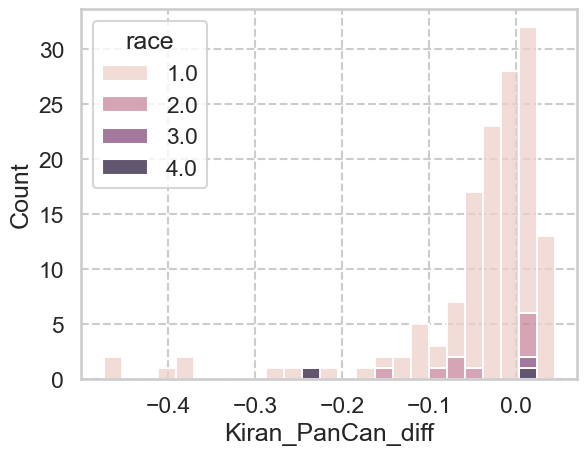

In [28]:
sns.histplot(false_negatives, x='Kiran_PanCan_diff', hue='race', multiple='stack')

### Racial differences

In [29]:
race_fns = {
    "white": false_negatives.query("race == 1"),
    "black": false_negatives.query("race == 2"),
}

In [30]:
for m in race_fns:
    print(m, len(race_fns[m]))

white 130
black 9


In [31]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fns).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).head(30)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
23,demo,WhiteOrBlack,1.0,130.0,100.0000,0.0,0.0000,100.0000
12,demo,race,1.0,130.0,100.0000,0.0,0.0000,100.0000
20,demo,NonHispanicWhite,1.0,130.0,100.0000,0.0,0.0000,100.0000
139,lungcanc,Squamous_cell_carcinoma,1.0,32.0,24.6154,0.0,0.0000,24.6154
26,smoke,cigar,1.0,28.0,21.5385,0.0,0.0000,21.5385
152,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710
22,demo,HighSchoolPlus,1.0,127.0,97.6923,7.0,77.7778,19.9145
30,smoke,pipe,1.0,25.0,19.2308,0.0,0.0000,19.2308
15,demo,Gender,1.0,67.0,51.5385,3.0,33.3333,18.2052
8,demo,educat,4.0,20.0,15.3846,0.0,0.0000,15.3846


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
13,demo,race,2.0,0.0,0.0000,9.0,100.0000,-100.0000
24,demo,WhiteOrBlack,2.0,0.0,0.0000,9.0,100.0000,-100.0000
28,smoke,cigsmok,1.0,71.0,54.6154,9.0,100.0000,-45.3846
83,disease,diaghype,1.0,50.0,38.4615,7.0,77.7778,-39.3163
129,other,wrknomask,1.0,28.0,21.5385,4.0,44.4444,-22.9059
75,disease,diagdiab,1.0,16.0,12.3077,3.0,33.3333,-21.0256
40,work,wrkbaki,1.0,2.0,1.5385,2.0,22.2222,-20.6837
42,work,wrkbutc,1.0,2.0,1.5385,2.0,22.2222,-20.6837
5,demo,educat,1.0,3.0,2.3077,2.0,22.2222,-19.9145
155,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453


In [32]:
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).query('category == "nodule"'))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).query('category == "nodule"')   

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
125,nodule,PartSolid,1.0,23.0,17.6923,1.0,11.1111,6.5812
115,nodule,Spiculation,1.0,1.0,0.7692,0.0,0.0000,0.7692
123,nodule,NonSolid,1.0,27.0,20.7692,2.0,22.2222,-1.4530
117,nodule,NoduleInUpperLung,1.0,81.0,62.3077,6.0,66.6667,-4.3590
119,nodule,Solid,1.0,80.0,61.5385,6.0,66.6667,-5.1282


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
119,nodule,Solid,1.0,80.0,61.5385,6.0,66.6667,-5.1282
117,nodule,NoduleInUpperLung,1.0,81.0,62.3077,6.0,66.6667,-4.3590
123,nodule,NonSolid,1.0,27.0,20.7692,2.0,22.2222,-1.4530
115,nodule,Spiculation,1.0,1.0,0.7692,0.0,0.0000,0.7692
125,nodule,PartSolid,1.0,23.0,17.6923,1.0,11.1111,6.5812


In [35]:
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).query('attribute == "LC_stage"'))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).query('attribute == "LC_stage"')   

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
152,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710
156,lungcanc,LC_stage,310.0,10.0,7.6923,0.0,0.0000,7.6923
154,lungcanc,LC_stage,210.0,7.0,5.3846,0.0,0.0000,5.3846
159,lungcanc,LC_stage,NaN,3.0,2.3077,0.0,0.0000,2.3077
157,lungcanc,LC_stage,320.0,1.0,0.7692,0.0,0.0000,0.7692
153,lungcanc,LC_stage,120.0,10.0,7.6923,1.0,11.1111,-3.4188
158,lungcanc,LC_stage,400.0,11.0,8.4615,2.0,22.2222,-13.7607
155,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
155,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453
158,lungcanc,LC_stage,400.0,11.0,8.4615,2.0,22.2222,-13.7607
153,lungcanc,LC_stage,120.0,10.0,7.6923,1.0,11.1111,-3.4188
157,lungcanc,LC_stage,320.0,1.0,0.7692,0.0,0.0000,0.7692
159,lungcanc,LC_stage,NaN,3.0,2.3077,0.0,0.0000,2.3077
154,lungcanc,LC_stage,210.0,7.0,5.3846,0.0,0.0000,5.3846
156,lungcanc,LC_stage,310.0,10.0,7.6923,0.0,0.0000,7.6923
152,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710


In [33]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fns)
display(num_demo_splits.sort_values(by='diff_white_black', ascending=False).head(20))
num_demo_splits.sort_values(by='diff_white_black', ascending=True).head(20)

,category,attribute,value,white,black,diff_white_black
9,smoke,pkyr,mean,62.6050,41.1111,21.4939
8,smoke,pkyr,50%,55.5000,40.0000,15.5000
12,smoke,smokeday,50%,30.0000,20.0000,10.0000
13,smoke,smokeday,mean,29.3154,20.0000,9.3154
0,demo,height,50%,68.0000,64.0000,4.0000
1,demo,height,mean,67.6846,64.5556,3.1290
14,smoke,smokeyr,50%,43.0000,40.0000,3.0000
15,smoke,smokeyr,mean,43.1385,41.1111,2.0274
5,demo,Age,mean,63.8692,63.1111,0.7581
17,other,NoduleCounts,mean,2.1769,2.0000,0.1769


,category,attribute,value,white,black,diff_white_black
21,lungcanc,LC_stage,mean,162.2835,200.0000,-37.7165
20,lungcanc,LC_stage,50%,110.0000,120.0000,-10.0000
3,demo,weight,mean,178.4923,188.4444,-9.9521
7,demo,BMI,mean,27.3050,33.1619,-5.8569
6,demo,BMI,50%,27.1279,32.5531,-5.4252
10,smoke,smokeage,50%,16.0000,20.0000,-4.0000
11,smoke,smokeage,mean,16.5308,19.3333,-2.8025
2,demo,weight,50%,175.5000,178.0000,-2.5000
4,demo,Age,50%,63.0000,65.0000,-2.0000
18,other,Diameter [mm],50%,7.4500,8.7000,-1.2500


<Axes: xlabel='pkyr', ylabel='Density'>

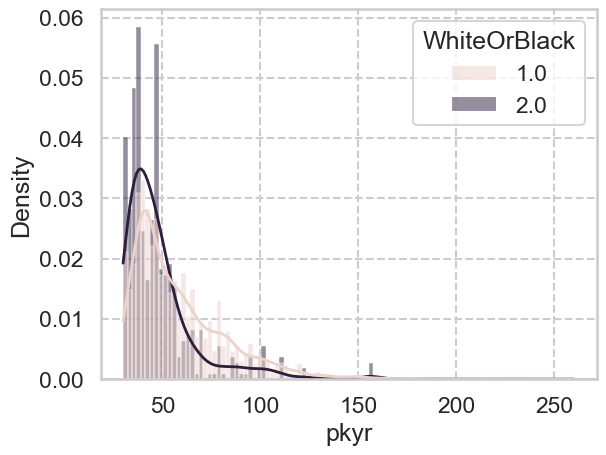

In [34]:
sns.histplot(data=nlst_preds, x='pkyr', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='density')